In [79]:
import numpy as np
import open3d as o3d
import os
import pathlib

from evo.core.trajectory import PosePath3D, PoseTrajectory3D
from evo.tools.file_interface import write_tum_trajectory_file, read_tum_trajectory_file, read_kitti_poses_file
from evo.core.lie_algebra import se3_inverse
from scipy.spatial.transform import Rotation as R
from tools.tum_tools import *
from tools.tum_plots import *
from tools.tum_definitions import *
from tools.tum_definitions import KISS_CONFIG as config

from pykitti.utils import read_calib_file, transform_from_rot_trans

from os import path

root = "/mnt/d/thesis/datasets/kitti/sequences"

sequence = "05"

%matplotlib widget

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
bin_root = path.join(root, sequence, "velodyne")
pcd_root = path.join(root, sequence, "pcd")

file_list = []
for f in os.listdir(bin_root):
    if f.endswith(".bin"):
        file_list.append(f)
file_list.sort()

In [22]:
if not path.exists(pcd_root):
    os.makedirs(pcd_root)

for i, f in enumerate(file_list,1):
   bin_file = path.join(bin_root, f)
   pcd_file = path.join(pcd_root, f"{pathlib.Path(f).stem}.pcd")
   
   # Load binary point cloud
   bin_pcd = np.fromfile(bin_file, dtype=np.float32)

   points = bin_pcd.reshape((-1, 4))[:, 0:3]
   o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
   o3d.io.write_point_cloud(pcd_file, o3d_pcd)
   print(f"Processed {i}/{len(file_list)}", end="\r")

In [23]:
def get_kiss_poses(dataset: dict, gt_poses=None):
    for name, value in dataset.items():
        print(f"Proccesing {name}")
        path = value[0]
        kiss_poses, trajectory_poses, timestamps = run_kiss_icp_pipeline(path, config, gt_poses)
        dataset[name] = (path, kiss_poses, trajectory_poses, timestamps)

In [24]:
seq = "02"
kitti = {
    seq : (f"{root}/{seq}" ,)
}
get_kiss_poses(kitti)

Proccesing 02
Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required


  0%|          | 0/4661 [00:00<?, ? frames/s]

[WARNING] No GT poses available, skipping evaluation


In [25]:
t = kitti[seq][3]
stamps = range(len(kitti[seq][1]))
traj = PoseTrajectory3D(poses_se3=kitti[seq][1], timestamps=stamps)
write_tum_trajectory_file(path.join(root, sequence, "poses", "raw_kiss.tum"), traj)

INFO - 2023-12-22 20:02:21,687 - file_interface - Trajectory saved to: /mnt/d/thesis/datasets/kitti/sequences/02/poses/raw_kiss.tum


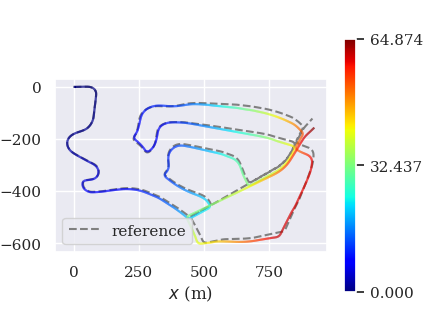

In [2]:
sequence = "02"

def imu_pose_to_lidar(poses):
    def _load_calib_rigid(filename):
        """Read a rigid transform calibration file as a numpy.array."""
        filepath = os.path.join(filename)
        data = read_calib_file(filepath)
        result = np.identity(4)
        result[:3,:] = data["Tr"].reshape(3,4)
        return result

    T_velo_imu = _load_calib_rigid(path.join(root, sequence, "calib.txt"))
    
    """Convert the imu poses to velodyne frame."""
    T_imu_velo = np.linalg.inv(T_velo_imu)
    return T_imu_velo @ poses @ T_velo_imu

# kiss = read_tum_trajectory_file(path.join(root, sequence, "poses", "raw_kiss.tum"))
kiss = read_tum_trajectory_file(path.join(root, sequence, "poses", "raw_kiss.tum"))

ref = read_kitti_poses_file(path.join(root, sequence, f"{sequence}.txt"))
ref = PosePath3D(poses_se3=imu_pose_to_lidar(ref.poses_se3))

# correct = np.identity(4)
# correct[:3, :3] = R.from_euler('xyz', [0, 0, -80]).as_matrix()

# poses = [np.array([p[0], p[2], -p[1]]) for p in ref.positions_xyz]
# gt = PosePath3D(orientations_quat_wxyz=ref.orientations_quat_wxyz, positions_xyz=poses)
# gt.align_origin(PosePath3D(poses_se3=[correct]))

metric = plot_compare((ref, kiss), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

In [63]:
indices = []
submap_lengths = []
for i in os.listdir(path.join(root, sequence, "submaps")):
    if not i.endswith(".indices"): continue
    
    with open(path.join(root, sequence, "submaps", i)) as f:
        idx_list = [int(e) -1 for e in f.readline().split(', ') if int(e)]
        submap_lengths.append(len(idx_list))
        indices.extend(idx_list)

global_poses = read_tum_trajectory_file(path.join(root, sequence, "debug_poses", "global_poses_optimized.tum"))
global_poses_orig = read_tum_trajectory_file(path.join(root, sequence, "debug_poses", "global_poses_original.tum"))
        
traj_optim_submaps = read_kitti_poses_file(path.join(root, sequence, "debug_poses", "submap_optimized.kitti"))
traj_no_optim = read_kitti_poses_file(path.join(root, sequence,   "debug_poses", "submap_original.kitti"))

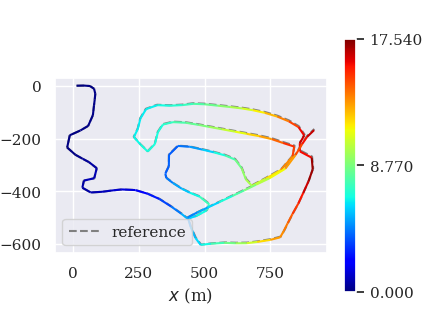

In [57]:
# Compare un-optimized vs. optimized global poses
metric = plot_compare((global_poses_orig, global_poses), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

In [58]:
# Need to align longer trajectories to reduced number of poses
kiss_aligned = deepcopy(kiss)
kiss_aligned.reduce_to_ids(indices)
ref_aligned = deepcopy(ref)
ref_aligned.reduce_to_ids(indices)

In [59]:
relative_global_poses = []
for i, pose in enumerate(global_poses.poses_se3):
    if i == 0:
        relative_global_poses.append(pose)
    else:
        relative_global_poses.append(relative_global_poses[-1] * pose)

In [123]:

aligned_submap_poses = []

lower = 0
upper = 0
# for num_poses, trans in zip(submap_lengths, relative_global_poses):
for num_poses, trans in zip(submap_lengths, global_poses.poses_se3):
    
    lower = upper
    upper += num_poses
    
    poses = traj_optim_submaps.poses_se3[lower:upper]
    
    mid_pose = poses[len(poses) // 2]
    
    transform = trans @ se3_inverse(mid_pose)
    
    # print(transform)
    # print(mid_pose)
    # print(mid_pose)
    # break
        
    aligned_submap_poses.extend((se3_inverse(transform) @ p for p in poses))
    
    lower += num_poses
    
traj_aligned_submaps = PosePath3D(poses_se3=aligned_submap_poses)

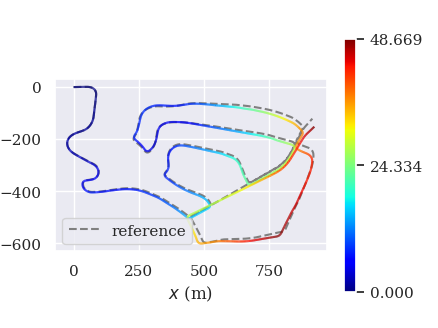

In [124]:
# metric = plot_compare((ref_aligned, kiss_aligned), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)
metric = plot_compare((ref_aligned, traj_aligned_submaps), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

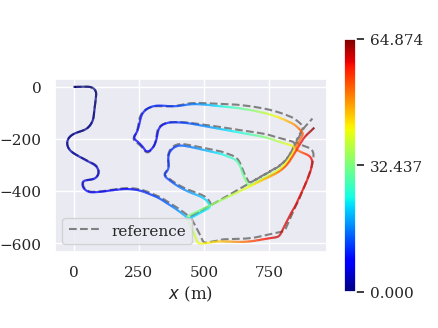

In [125]:
metric = plot_compare((ref_aligned, kiss_aligned), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)